In [1]:
print("Setting CUDA devices...")
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="5"

from fastai.conv_learner import *
from fastai.dataset import *

import pandas as pd
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tnrange, tqdm_notebook
from scipy import ndimage

print("Setting variables...")
DATASET_ROOT = '/media/ssd-data/datasets/airbus/'
#DATASET_ROOT = '/media/data/dev/datasets/airbus/'
PATH = DATASET_ROOT
TRAIN = DATASET_ROOT + 'train/'
TEST = DATASET_ROOT + 'test/'
SEGMENTATION = DATASET_ROOT + 'train_ship_segmentations.csv'
PRETRAINED_DETECTION_PATH = DATASET_ROOT + 'fine-tuning-resnet34-on-ship-detection/models/'
#PRETRAINED = DATASET_ROOT + 'models/Resnet34_lable_256_1.h5'
PRETRAINED = DATASET_ROOT + 'models/Resnet34_384_7.h5'

PRETRAINED_SEGMENTATION_PATH = DATASET_ROOT + 'unet34-dice-0-87/models/'
DETECTION_TEST_PRED = DATASET_ROOT + 'fine-tuning-resnet34-on-ship-detection/ship_detection.csv'
exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg'] #corrupted images
!ls {PATH}/models

Setting CUDA devices...


/home/ben/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Setting variables...
Resnet34_384_7.h5	 tmp.h5		  Unet34_384_1.h5
Resnet34_lable_256_1.h5  Unet34_256_0.h5  Unet34_768_1.h5
Resnet34_lable_384_1.h5  Unet34_256_1.h5  Unet34_768_3.h5


In [2]:
nw = 16   #number of workers for data loader
arch = resnet34 #specify target architecture
train_names = [f for f in os.listdir(TRAIN)]
test_names = [f for f in os.listdir(TEST)]
for el in exclude_list:
    if(el in train_names): train_names.remove(el)
    if(el in test_names): test_names.remove(el)
#5% of data in the validation set is sufficient for model evaluation
tr_n, val_n = train_test_split(train_names, test_size=0.05, random_state=42)
segmentation_df = pd.read_csv(os.path.join(PATH, SEGMENTATION)).set_index('ImageId')


def cut_empty(names):
    return [name for name in names 
            if(type(segmentation_df.loc[name]['EncodedPixels']) != float)]

tr_n = cut_empty(tr_n)
val_n = cut_empty(val_n)

def get_mask(img_id, df):
    shape = (768,768)
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    masks = df.loc[img_id]['EncodedPixels']
    if(type(masks) == float): return img.reshape(shape)
    if(type(masks) == str): masks = [masks]
    for mask in masks:
        s = mask.split()
        for i in range(len(s)//2):
            start = int(s[2*i]) - 1
            length = int(s[2*i+1])
            img[start:start+length] = 1
    return img.reshape(shape).T

def get_data(sz,bs):
    #data augmentation
    aug_tfms = [RandomRotate(20, tfm_y=TfmType.CLASS),
                RandomDihedral(tfm_y=TfmType.CLASS),
                RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS)]
    tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, 
                aug_tfms=aug_tfms)
    tr_names = tr_n if (len(tr_n)%bs == 0) else tr_n[:-(len(tr_n)%bs)] #cut incomplete batch
    ds = ImageData.get_ds(pdFilesDataset, (tr_names,TRAIN), 
                (val_n,TRAIN), tfms, test=(test_names,TEST))
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
    #md.is_multi = False
    return md

class pdFilesDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.segmentation_df = pd.read_csv(SEGMENTATION).set_index('ImageId')
        super().__init__(fnames, transform, path)
    
    def get_x(self, i):
        img = open_image(os.path.join(self.path, self.fnames[i]))
        if self.sz == 768: return img 
        else: return cv2.resize(img, (self.sz, self.sz))
    
    def get_y(self, i):
        mask = np.zeros((768,768), dtype=np.uint8) if (self.path == TEST) \
            else get_mask(self.fnames[i], self.segmentation_df)
        img = Image.fromarray(mask).resize((self.sz, self.sz)).convert('RGB')
        return np.array(img).astype(np.float32)
    
    def get_c(self): return 0

cut,lr_cut = model_meta[arch]
def get_base():                   #load ResNet34 model
    layers = cut_model(arch(True), cut)
    return nn.Sequential(*layers)

def load_pretrained(model, path): #load a model pretrained on ship/no-ship classification
    weights = torch.load(PRETRAINED, map_location=lambda storage, loc: storage)
    model.load_state_dict(weights, strict=False)
            
    return model
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()
    
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()
            
class UnetModel():
    def __init__(self,model,name='Unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.mean()

class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)
        
    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()
    
def dice(pred, targs):
    pred = (pred>0).float()
    return 2.0 * (pred*targs).sum() / ((pred+targs).sum() + 1.0)

def IoU(pred, targs):
    pred = (pred>0).float()
    intersection = (pred*targs).sum()
    return intersection / ((pred+targs).sum() - intersection + 1.0)

m_base = load_pretrained(get_base(),PRETRAINED)
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [3]:
#models.model

In [4]:
sz = 256 #image size
bs = 64  #batch size 64 for 256x256 => 8GB

md = get_data(sz,bs)

In [5]:

learn = ConvLearner(md, models)
# Choose GPU
#learn.models.model = torch.nn.DataParallel(learn.models.model,device_ids=[3, 4, 5, 6])

learn.opt_fn=optim.Adam
learn.crit = MixedLoss(10.0, 2.0)
learn.metrics=[accuracy_thresh(0.5),dice,IoU]
wd=1e-7

In [6]:
learn.freeze_to(1)


In [7]:
learn.fit(1e-2,1,wds=wd,cycle_len=1,use_clr=(5,8))

epoch      trn_loss   val_loss   <lambda>   dice       IoU        
    0      0.324327   0.313564   0.99809    0.794296   0.659952  



[array([0.31356]), 0.9980896016029498, 0.7942963583357016, 0.6599515869297107]

In [8]:
learn.save('Unet34_256_0')

In [9]:
lr = 1e-3
lrs = np.array([lr/100,lr/10,lr])
learn.unfreeze() #unfreeze the encoder
learn.bn_freeze(True)

In [10]:
learn.fit(lr,2,wds=wd,cycle_len=1,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice       IoU        
    0      0.288583   0.272065   0.998345   0.818736   0.69382   
    1      0.273072   0.264039   0.998376   0.822882   0.699786  



[array([0.26404]), 0.9983757854237352, 0.8228818666178108, 0.699786131822093]

In [11]:
learn.fit(lr/2,2,wds=wd,cycle_len=2,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice       IoU        
    0      0.26974    0.253589   0.99843    0.829037   0.70855   
    1      0.243662   0.236944   0.998519   0.839327   0.723616  
    2      0.258686   0.248492   0.998464   0.831778   0.712694  
    3      0.226983   0.224186   0.99859    0.846681   0.73453   



[array([0.22419]), 0.9985900913915369, 0.8466806855670193, 0.7345297287198563]

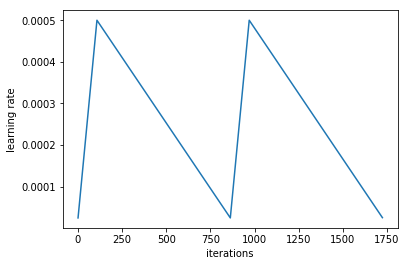

In [12]:
learn.sched.plot_lr()

In [13]:
learn.save('Unet34_256_1')

In [14]:
learn.load('Unet34_256_1')

In [15]:
sz = 384 #image size
bs = 16  #batch size
lr = 1e-3
md = get_data(sz,bs)
learn.set_data(md)
learn.unfreeze()
learn.bn_freeze(True)

In [16]:
learn.fit(lr/8,1,wds=wd,cycle_len=2,use_clr=(10,8))

epoch      trn_loss   val_loss   <lambda>   dice       IoU        
    0      0.230096   0.223736   0.998683   0.848233   0.739993  
    1      0.215476   0.209942   0.998738   0.856411   0.751862  



[array([0.20994]), 0.9987378558441541, 0.8564107832909895, 0.7518619420662054]

In [17]:
learn.save('Unet34_384_1')

In [18]:
sz = 768 #image size
bs = 6  #batch size 6 x 768 => 10GB

md = get_data(sz,bs)
learn.set_data(md)
learn.unfreeze()
learn.bn_freeze(True)

## use_clr : Circular LR schedule

Generally something around (10,10) seems to work pretty well. If you’ve got more epochs or larger dataset, try changing the first number to 40. For small datasets, try changing the second number to 5.
The first one, div, is by how much your learning rate is divided to get the minimum value (the maximum value is the lr you put as a parameter). The second argument seems to be the way you split your cycle between increasing and decreasing: 1/5 of growth and 4/5 of descent.
http://forums.fast.ai/t/understanding-use-clr/13969

In [19]:
# learn.fit(lr/20,1,wds=wd,cycle_len=1,use_clr=(10,8)) => 
#epoch      trn_loss   val_loss   <lambda>   dice       IoU        
#    0      0.292029   0.278166   0.998504   0.816557   0.701538 
learn.fit(lr/20,3,wds=wd,cycle_len=1,use_clr=(40,10))

epoch      trn_loss   val_loss   <lambda>   dice       IoU        
    0      0.268032   0.272434   0.998511   0.818593   0.703227  
    1      0.274174   0.256402   0.998586   0.828161   0.716163  
    2      0.250298   0.242112   0.998645   0.835857   0.725962  



[array([0.24211]), 0.9986450742654133, 0.8358571992909076, 0.7259621983408832]

In [20]:
learn.save('Unet34_768_3')

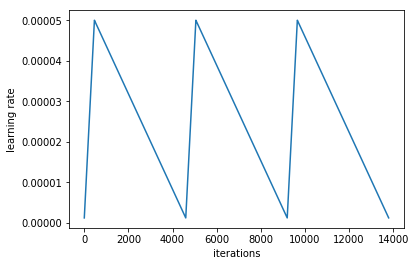

In [21]:
learn.sched.plot_lr()

In [22]:
#learn.sched.plot()

## SGDR - cyclical LR with CosAnnealing
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
The cycle_len parameter governs how long we’re going to ride that cosine curve as we decrease… decrease… decrease… the learning rate. Cycles are measured in epochs, so cycle_len=1 by itself would mean to continually decrease the learning rate over the course of one epoch, and then jump it back up. The cycle_mult parameter says to multiply the length of a cycle by something (in this case, 2) as soon as you finish one.

So, here we’re going to do three cycles, of lengths (in epochs): 1, 2, and 4. So, 7 epochs in total, but our SGDR only restarts twice.

In [23]:
learn.fit(lr,3,wds=wd, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   <lambda>   dice       IoU        
    0      0.489131   0.44914    0.997878   0.730546   0.595535  
    1      0.476312   0.465198   0.997922   0.725204   0.591544  
    2      0.43783    0.390013   0.998114   0.757997   0.63012   
    3      0.466871   0.453389   0.997943   0.730775   0.598312  
    4      0.394212   0.41402    0.998016   0.751336   0.622119  
    5      0.341768   0.35379    0.998291   0.779142   0.657037  
    6      0.298081   0.34065    0.998346   0.785323   0.665089  



[array([0.34065]), 0.998346031725123, 0.7853231951397215, 0.6650891343696926]

In [24]:
learn.save('Unet34_768_7')

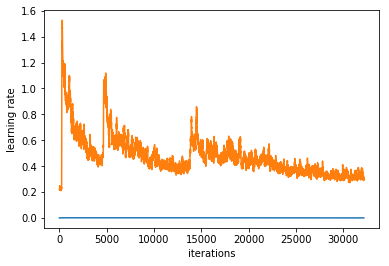

In [26]:
learn.sched.plot_lr()

In [1]:
learn.sched.plot_loss()

NameError: name 'learn' is not defined